# Poiseuille flows

```{figure} ../images/channelprofile3.png
---
width: 300px
height: 200px
name: channel
---
Channel flow is a pressure driven Poiseuille flow
```

Poiseuille flows are driven by pumps that forces the fluid to flow through pressure. Fluids flow naturally from regions of high pressure to regions of low pressure. Typical examples are cylindrical pipe flow and other duct flows. A fully developed plane channel flow is shown above. Fully developed Poiseuille flows exists only far from the entrances and exits of the ducts, where the flow is aligned parallel to the duct walls. If we assume the flow is in the x-direction, as shown in Fig. 3-6 of {cite}`white06`, then the velocity vector is $\boldsymbol{u}(y,z,t)=(u(y,z,t),0,0)$ and Navier-Stokes equations can be simplified to

```{math}
:label: eq:planechannelNS
\begin{aligned}
  \frac{\partial u}{\partial t} &= \nu \nabla ^2 u - \frac{1}{\rho}\frac{\mathrm{d} p}{\mathrm{d} x},  \\
  \frac{\partial u}{\partial x} &= 0,
\end{aligned}
```

The equations are still linear because the flow is aligned in one direction and convection is thus zero. The only difference from Couette flow is that there is a non-zero source term in the pressure gradient. The transient term on the left hand side is zero for stationary flows.

The total volume flow, $Q$, through any duct is found by integrating the velocity over the entire cross section, $C$, of the duct

```{math}
:label: eq:Q
  Q = \displaystyle{\int_{\mathrm{C}}} u \mathrm{d}A.
```

Using {eq}`eq:Q` it is also possible to define an average velocity, $\overline{u}$, through the duct

```{math}
  \overline{u} = \frac{Q}{A}.
```

The average velocity is subsequently used to define the Reynolds number and certain friction factors - engineering tools used to classify duct flow.

## Steady Poiseuille flows

### The circular pipe

For a steady cylindrical pipe flow with radius $r_0$ the solution to {eq}`eq:planechannelNS` is found simply by integrating twice and applying boundary conditions:

```{math}
\begin{aligned}
  \frac{\nu}{r}\frac{\mathrm{d}}{\mathrm{d} r}\left(r \frac{\mathrm{d} u}{\mathrm{d} r} \right) &= \frac{1}{\rho}\frac{\mathrm{d} p}{\mathrm{d} x}, \\
  \frac{\mathrm{d}}{\mathrm{d} r}\left( r \frac{\mathrm{d} u }{\mathrm{d} r} \right) &= \frac{r}{\mu}\frac{\mathrm{d} p}{\mathrm{d} x}, \\
   r \frac{\mathrm{d} u}{\mathrm{d} r} &= \frac{r^2}{2\mu}\frac{\mathrm{d} p}{\mathrm{d} x} + C_1, \\
   \frac{\mathrm{d} u}{\mathrm{d} r} &= \frac{r}{2\mu}\frac{\mathrm{d} p}{\mathrm{d} x} + \frac{C_1}{r}, \\
u(r) &= \frac{r^2}{4\mu}\frac{\mathrm{d} p}{\mathrm{d} x} + C_1\ln(r)+ C_2,
\end{aligned}
```

where $C_1$ and $C_2$ are integration constants. The constant $C_1$ must be zero for the flow at the center of the pipe to remain finite. The condition at the wall $u(r_0)=0$ gives

```{math}
  C_2 = -\frac{r_0^2}{4\mu}\frac{\partial p}{\partial x},
```

which leads to the final expression for the pipe flow

```{math}
:label: eq:SteadyPoiseuille
  u(r) = -\frac{1}{4\mu}\frac{\partial p}{\partial x} \left(r_0^2 - r^2 \right)
```


### Noncircular ducts

For steady and fully developed duct flows the governing equation is simply the Poisson equation

```{math}
:label: eq:poisson
  \nabla ^2 u = \frac{1}{\mu} \frac{\mathrm{d}p}{\mathrm{d}x}.
```

The equation is linear and very easy to solve numerically for any shape of the duct. There is also a great number of analytical solutions available for noncircular duct flows, solutions that can be used to verify the quality of the numerical software. The duct solutions are often used for specifying inlet profiles to much more complicating geometries, where the flow enters the geometry through a duct.

In the code blelow we show a FEniCS code used to solve {eq}`eq:poisson` for a rectangular duct spanned as $-a \leqslant y \leqslant a$ and $-b \leqslant z \leqslant b$ . Of interest here is the computation of the very complicated analytical expression for the velocity given as

```{math}
:label: eq:rectangle
  u(z,y) = \frac{16a^2}{\mu \pi^3}\left(-\frac{\mathrm{d}p}{\mathrm{d}x} \right) \sum_{i=1,3,5,...}^{\infty} (-1)^{\frac{i-1}{2}} \left[1-\frac{\cosh (i \pi z)/2a}{\cosh (i \pi b) / 2a} \right] \times \frac{\cos(i \pi y) / 2a}{i^3}.
```

The FEniCS implementation of this exact solution overloads the `UserExpression` class and  you should recognize {eq}`eq:rectangle` in the overloaded `eval` method. Here $x$ is an array of the coordinates and $x[0]$ and $x[1]$ represent $y$ and $z$ respectively. Unfortunately, the Python `UserExpression` `u_exact` is quite slow to interpolate due to the non-vectorized for-loop. For this reason, a C++ version of the same `Expression` is implemented instead, which speeds up the program with approximately a factor of 45.


In [1]:
from dolfin import *
from numpy import cosh, cos
set_log_active(False)

dpdx = Constant(-0.01)
mu = Constant(0.01)
a = 2
b = 1

factor = 16.*a*a/mu(0)/pi**3*(-dpdx(0))
class u_exact(UserExpression):

    def eval(self, value, x):
        u = 0
        for i in range(1, 500, 2):
            u += ((-1)**((i-1)/2)*(1-cosh(i*pi*x[1]/2./a)/
                   cosh(i*pi*b/2/a))*cos(i*pi*x[0]/2./a)/i**3)
        value[0] = u * factor

# Much faster C++ version
ue_code = '''
#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
namespace py = pybind11;

#include <dolfin/function/Expression.h>

class U : public dolfin::Expression
{
  public:

    double a, b, mu, dpdx;

  void eval(Eigen::Ref<Eigen::VectorXd> values,
            Eigen::Ref<const Eigen::VectorXd> x,
            const ufc::cell& cell) const override
    {
      double u = 0.;
      double factor = 16.*a*a/mu/pow(DOLFIN_PI, 3)*(-dpdx);
      for (std::size_t i=1; i<500; i=i+2)
        u += pow(-1, (i-1)/2 % 2)*(1.-cosh(i*DOLFIN_PI*x[1]/2./a)/
           cosh(i*DOLFIN_PI*b/2./a))*cos(i*DOLFIN_PI*x[0]/2./a)/pow(i, 3);
      values[0] = u*factor;
    }
};

PYBIND11_MODULE(SIGNATURE, m)
{
  py::class_<U, std::shared_ptr<U>, dolfin::Expression>
    (m, "U")
    .def(py::init<>())
    .def_readwrite("a", &U::a)
    .def_readwrite("b", &U::b)
    .def_readwrite("mu", &U::mu)
    .def_readwrite("dpdx", &U::dpdx);
}
'''
u_c = CompiledExpression(compile_cpp_code(ue_code).U(), a=float(a), b=float(b),
                         mu=float(mu(0)), dpdx=float(dpdx(0)), degree=1)

def main(N, degree=1):
    mesh = RectangleMesh(Point(-a, -b), Point(a, b), N, N)
    V = FunctionSpace(mesh, 'CG', degree)
    u = TrialFunction(V)
    v = TestFunction(V)
    F = inner(grad(u), grad(v))*dx + 1/mu*dpdx*v*dx
    bc = DirichletBC(V, Constant(0), DomainBoundary())
    u_ = Function(V)
    solve(lhs(F) == rhs(F), u_, bcs=bc)

    #u_e = interpolate(u_exact(), V)  # slow, but otherwise the same as below
    u_e = interpolate(u_c, V)
    bc.apply(u_e.vector())
    u_error = errornorm(u_e, u_, degree_rise=0)
    return u_error, mesh.hmin()

E = []; h = []; degree = 1
for n in [5, 10, 20, 40, 60]:
    ei, hi = main(n, degree=degree)
    E.append(ei)
    h.append(hi)

from math import log as ln
for i in range(1, len(E)):
    r = ln(E[i]/E[i-1])/ln(h[i]/h[i-1])
    print("h=%2.2E E=%2.2E r=%.2f" %(h[i], E[i], r))


h=4.47E-01 E=6.41E-03 r=1.76
h=2.24E-01 E=1.69E-03 r=1.93
h=1.12E-01 E=4.28E-04 r=1.98
h=7.45E-02 E=1.91E-04 r=1.99


(analysing-the-error)=

#### Analysing the error

In the code for the rectangular duct we compute the errornorm that compares the computed finite element solution with the exact solution. This error will depend on the mesh size and the order of the polynomial approximation. The error should disappear in the limit of a highly resolved mesh or for very high order polynomials. Given the polynomial order, the rate at which the error disappears can be computed by performing experiments with meshes of different resolution. We assume that the error for a mesh of element size $h_i$ can be written as $E_i=Ch_i^r$, where $C$ is a constant. We now want to find the order $r$ of which the error disappears with mesh refinement. The order $r$ can be found by computing $E_i$ for two different $h_i$'s, i.e., $E_i=h_i^r$ and $E_{i-1}=h_{i-1}^r$, and then isolate $r$:

```{math}
 r = \frac{\ln (E_i/E_{i-1})}{\ln (h_i/h_{i-1})}.
```

It is this error that is printed out at the end above. Changing the degree in the `FunctionSpace` to 2 the order should be three. Lets try it:


In [2]:
E = []; h = []; degree = 2
for n in [5, 10, 20, 40, 60]:
    ei, hi = main(n, degree=degree)
    E.append(ei)
    h.append(hi)

from math import log as ln
for i in range(1, len(E)):
    r = ln(E[i]/E[i-1])/ln(h[i]/h[i-1])
    print("h=%2.2E E=%2.2E r=%.2f" %(h[i], E[i], r))

h=4.47E-01 E=2.14E-04 r=3.13
h=2.24E-01 E=2.63E-05 r=3.03
h=1.12E-01 E=3.25E-06 r=3.02
h=7.45E-02 E=9.41E-07 r=3.05


### Combined Couette and Poiseuille flow

It is possible to combine an applied pressure gradient with moving walls. Such flows are termed combined Couette-Poiseuille flows and they are governed by the Poiseuille {eq}`eq:planechannelNS`. The solution to a combined Couette-Poiseuille flow can be found as the sum of a Couette solution $u_c$ using zero pressure gradient and a homogeneous Poiseuille solution $u_p$ using zero velocity on walls. For a plane channel with $u(h) = U$ and $u(-h)=0$ the solution is thus found by solving the two problems, for Couette

```{math}
:label: eq:CouetteComb
  \nabla^2 u_c = 0, \quad u_c(h)=U,\,u_c(-h)=0,
```

and Poiseuille

```{math}
:label: eq:PoiseuilleComb
\nabla^2 u_p = \frac{1}{\mu}\frac{\mathrm{d}p}{\mathrm{d}x}, \quad u_p(\pm h)=0. 
```

The combined solution $u = u_c + u_p$ is the solution to the original problem. This can be seen by summing {eq}`eq:CouetteComb` and {eq}`eq:PoiseuilleComb` and also evidently $u(h) = u_c(h)+u_p(h) = U$ and similarily for $y=-h$. The superposition is possible simply because the governing equation is linear. The principle is used also for transient flows in both Chapters (3-4) and (3-5).

## Unsteady duct flows

Unsteady plane shear flows are experienced by fluids where the driving forces are suddenly or continuously changed. A fluid initially at rest will for example respond to a sudden increase in the pressure gradient (we suddenly start the pump) and the volume flow through the duct will then increase monotonically until steady state is reached. The applied pressure gradient may also vary in time. Another scenario is that a wall is suddenly or continuously set in motion, dragging with it the fluid initially at rest. Common for these flows is that the transient term in the Navier Stokes equations cannot be neglected.

### Starting flow in a cylindrical pipe

When a fluid initially at rest suddenly is exposed to a constant pressure gradient, the fluid will start to move as a response to the applied forces and the flow will increase for some time until the steady state Poiseuille flow profile {eq}`eq:SteadyPoiseuille` is reached. For convenience we modify this equation slightly here and write it for the steady velocity $u_s$ as

```{math}
  u_s = u_{max} \left(1-\tilde{r}^2 \right),
```

where

```{math}
  u_{max} = -\frac{r_0^2}{4\mu}\frac{\partial p}{\partial x}
```

and $\tilde{r}=r/r_0$. We use the superposition principle and split the equation into two contributions

```{math}
  u(r, t) = v(r, t) + u_s(r),
```

where $u(r,t)$ is the complete solution and $v(r,t)$ is the solution to the homogeneous {eq}`eq:planechannelNS` in cylinder coordinates:

```{math}
:label: eq:UnsteadyCyl
  \frac{\partial v}{\partial t} = \nu \left( \frac{\partial ^2 v}{\partial r^2} + \frac{1}{r} \frac{\partial v}{\partial r} \right), 
```

subject to boundary condition $v(r_0,t)=0$ and initial condition $v(r,0) = -u_s(r)$. The equation can be non-dimensionalized by multiplying with $r_0^2/\nu$ and using $\tilde{t}=t\nu/r_0^2$ and $\tilde{r}=r/r_0$

```{math}
:label: eq:UnsteadyCylNorm
  \frac{\partial v}{\partial \tilde{t}} = \frac{\partial ^2 v}{\partial \tilde{r}^2} + \frac{1}{\tilde{r}} \frac{\partial v}{\partial \tilde{r}}.
```

Equation {eq}`eq:UnsteadyCylNorm` can be solved using a separation of variables $v(\tilde{r},\tilde{t}) = V(\tilde{r})T(\tilde{t})$. Inserted into {eq}`eq:UnsteadyCylNorm` we obtain

```{math}
\begin{aligned}
 V \frac{\mathrm{d} T}{\mathrm{d} \tilde{t}} &= T \left( \frac{\mathrm{d}^2 V}{\mathrm{d}\tilde{r}^2} + \frac{1}{\tilde{r}} \frac{\mathrm{d}V}{\mathrm{d}\tilde{r}} \right), \\
  V  \dot{T} &= T \left( V^{''} + \frac{1}{\tilde{r}} V^{'} \right), \\
  \frac{\dot{T}}{T} &= \frac{V^{''} + \frac{1}{\tilde{r}} V^{'}}{V},
\end{aligned}
```

where the dot and apostrophe represent ordinary derivatives with respect to $\tilde{t}$ and $\tilde{r}$ respectively. Since the left hand side depends only on $\tilde{t}$ and the right hand side only on $\tilde{r}$, both sides must be equal to a constant. It turns out that the constant must be negative to satisfy the appropriate boundary conditions. We call the new constant $-\lambda^2$ and obtain the two separate ordinary differential equations

```{math}
\begin{aligned}
  \dot{T} + \lambda^2 T &= 0, \\
  \tilde{r}^2 V^{''} + \tilde{r} V^{'} + \lambda^2 \tilde{r}^2 V &= 0.
\end{aligned}
```

The first equation has solution

```{math}
T(t) = e^{-\lambda^2 \tilde{t}}.
```

The second equation can be rewritten using $x=\tilde{r}\lambda$ and chain rule differentiation leading to

```{math}
:label: eq:Besselequation
 x^2 V^{''} + x V^{'} + x^2 V = 0,
```

with the apostrophe here being a derivative with respect to $x$. Equation {eq}`eq:Besselequation` is Bessel's differential equation of zero order. The solution to Bessel's equation is the Bessel function of the first kind of order zero

```{math}
 J_0(x).
```

A solution to $V$ becomes

```{math}
V(\tilde{r}) = A J_0(\lambda \tilde{r}),
```

where $A$ is a constant. We now need to make sure that the boundary  and initial conditions are satisfied. The boundary condition requires
$V(1)=J_0(\lambda)=0$. The figure below shows how the Bessel function behaves. Apparently it looks somewhat like a damped cosine function with multiple roots that we call $\lambda_k$. The first four positive roots are located at  $ x = 2.4048, 5.5201, 8.6537, 11.7915$ corresponding to $\lambda_1, \lambda_2, \lambda_3, \lambda_4$.

```{figure} ../images/Besselplot.png
---
width: 400px
height: 300px
name: beselfunction
---
Bessel function
```

One general solution is thus

```{math}
  V(\tilde{r}) = A_k J_0(\lambda_k \tilde{r})
```

with a total solution

```{math}
  v(\tilde{r}, \tilde{t}) = A_k J_0(\lambda_k \tilde{r})  e^{-\lambda_k^2 \tilde{t}}.
```

Since the equations are linear we can use superposition and obtain a total solution simply by summing over multiple possible solutions

```{math}
v(\tilde{r}, \tilde{t}) = \sum_{k=1}^{\infty} A_k J_0(\lambda_k \tilde{r})  e^{-\lambda_k^2 \tilde{t}}.
```

We now have a solution consisting of many constants that satisfy the boundary condition. It remains to close these constants using the initial condition $v(\tilde{r}, 0) = -u_{max}(1-\tilde{r}^2)$.

We have

```{math}
:label: eq:Besselinit
  \sum_{k=1}^{\infty} A_k J_0(\lambda_k \tilde{r}) = -u_{max}(1-\tilde{r}^2)
```

and we want to find $A_k$. To this end we use orthogonality

```{math}
:label: eq:BesselOrthogonal
 \int_0^1 x J_n(\lambda_k x) J_n(\lambda_m x) dx = 0 \quad \mathrm{for\,} k \neq m
```

and orthonormality

```{math}
:label: eq:BesselOrthoNormal
 \int_0^1 x J_n(\lambda_k x) J_n(\lambda_k x) dx = \frac{J_{n+1}^2(\lambda_k)}{2}.
```

If {eq}`eq:Besselinit` is multiplied by $\tilde{r} J_0(\lambda_m \tilde{r})$ and integrated from zero to unity we get

```{math}
  \int_0^1 \tilde{r} J_0(\lambda_m \tilde{r}) \sum_{k=1}^{\infty} A_k J_0(\lambda_k \tilde{r}) \mathrm{d}\tilde{r} = -\int_0^1 u_{max}(1-\tilde{r}^2) \tilde{r} J_0(\lambda_m \tilde{r}) \mathrm{d}\tilde{r}.
```

We now use {eq}`eq:BesselOrthogonal` to eliminate all terms on the left hand side where $k \neq m$ and insert for {eq}`eq:BesselOrthoNormal`. The result is a closed expression for $A_k$

```{math}
:label: eq:BesselAk
  A_k = -\frac{2}{J_1^2(\lambda_k)} \int_0^1 \tilde{r} J_0(\lambda_k \tilde{r})u_{max}(1-\tilde{r}^2) \mathrm{d}\tilde{r}.
```

The integral on the right hand side can be evaluated exactly (details left out for now) leading to

```{math}
:label: eq:BesselAkfinal
  A_k = -\frac{4 u_{max} J_2(\lambda_k)}{\lambda_k^2 J_1^2(\lambda_k)} = -\frac{8 u_{max}}{\lambda_k^3 J_1(\lambda_k)}
```

The final solution to starting flow in a cylinder, {eq}`eq:UnsteadyCyl`, becomes

```{math}
 u(\tilde{r}, \tilde{t}) = u_{max}(1 - \tilde{r}^2) - \sum_{k=1}^{\infty} \frac{8 u_{max} J_0(\lambda_k \tilde{r})}{\lambda_k^3 J_1(\lambda_k)} e^{-\lambda_k^2 \tilde{t}}
```

in agreement with Eq. (3-96) in White  {cite}`white06`.


### Pipe flow due to an oscillating pressure gradient

Consider now the same problem as in the previous section, but with a pressure gradient that is oscillating in time

```{math}
  \frac{\partial p}{\partial x} = -\rho K e^{i\omega t},
```

where $i = \sqrt{-1}$ and

```{math}
  e^{i\omega t} = \cos \omega t + i \sin \omega t.
```

The governing equation for the cylinder is thus

```{math}
:label: eq:UnsteadyCyl2
  \frac{\partial u}{\partial t} = K e^{i\omega t} + \nu \left( \frac{\partial ^2 u}{\partial r^2} + \frac{1}{r} \frac{\partial u}{\partial r} \right).
```

We now want solve {eq}`eq:UnsteadyCyl2` with no-slip boundary conditions on the cylinder walls. We will neglect the initial condition and look only for a long-term steady oscillatory solution on the form

```{math}
:label: eq:OscPressureSol
  u(r, t) = e^{i\omega t} V(r).
```

That is, we look for a solution where all the transient behaviour is governed by an oscillating pressure gradient proportional to $e^{i\omega t}$.

Inserting for {eq}`eq:OscPressureSol` in {eq}`eq:UnsteadyCyl2` and using the same nomenclature as in the previous section we obtain

```{math}
\begin{aligned}
  V i\omega \cancel{e^{i\omega t}} &= K  \cancel{e^{i\omega t}} + \nu \cancel{e^{i\omega t}} \left(V'' + \frac{1}{r} V'\right) \\
  V i\omega &= K + \nu \left(V'' + \frac{1}{r} V'\right) \\
  r^2 V'' + r V' - \frac{i\omega}{\nu} r^2 V &= - \frac{K r^2}{\nu}.
\end{aligned}
```

Using $x=r\sqrt{i\omega/\nu}$ and chain rule differentiation the equation can be rewritten as

```{math}
:label: eq:intermediateV
    x^2 V'' + x V' - x^2 V = - \frac{K x^2}{i \omega},
```

where the apostrophe now represents differentiation with respect to $x$. This equation looks very much like a [modified Bessel equation](http://mathworld.wolfram.com/ModifiedBesselDifferentialEquation.html) of zero order. The only difference is the right hand side, which should be zero. To get rid of the right hand side we use another change of variables

```{math}
  V =  \hat{V} + \frac{K}{i \omega}
```

and insert this in {eq}`eq:intermediateV` such that

```{math}
    x^2 \hat{V}'' + x \hat{V}' - x^2 \hat{V} = 0.
```

The solution to the modified Bessel equation of zero order is the modified Bessel function of the first kind (the second kind cannot be used since this function is infinite for $x=0$) of zero order, $I_0$, so

```{math}
  \hat{V}(x) = A I_0(x),
```

or in terms of the ordinary Bessel function:

```{math}
  \hat{V}(x) = A J_0(-i x),
```

where $A$ is a constant. With this result we can now express the total solution as

```{math}
:label: eq:intOscPressureSol
  u(r, t) = e^{i\omega t} \left(A I_0(r\sqrt{i\omega/\nu}) +  \frac{K}{i \omega} \right).
```

The boundary condition requires $u(r_0, t)=0$, which determines $A$:

```{math}
  A = -\frac{K}{i \omega I_0(r_0 \sqrt{i \omega/ \nu})}.
```

Inserted into {eq}`eq:intOscPressureSol` we are left with

```{math}
  u(r, t) = \frac{K e^{i\omega t}}{i \omega} \left( 1 - \frac{I_0(r \sqrt{i \omega})}{I_0(r_0 \sqrt{i \omega/\nu})} \right),
```

or

```{math}
  u(r, t) = \frac{K e^{i\omega t}}{i \omega} \left( 1 - \frac{J_0(r \sqrt{-i \omega/\nu})}{J_0(r_0 \sqrt{-i \omega/\nu})} \right),
```

in accordance with Eq. 3-98 in {cite}`white06`.

The Bessel function can be found in the toolbox `scipy.special`. The solution is computed below for a relatively large normalized $\tilde{\omega}=\omega r_0^2/\nu = 10$. A smaller value of $\tilde{\omega}$ will result in velocity profiles closer to the steady Poiseuille profile $u_{max}(1-\tilde{r}^2)$.



0.0
10.471975511965978
20.943951023931955
31.415926535897928
41.88790204786391
52.35987755982989


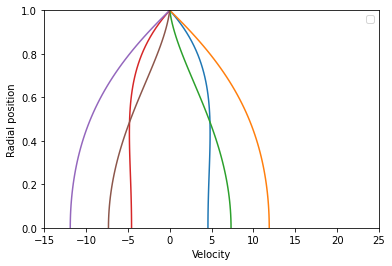

In [10]:
from numpy import *
import matplotlib.pyplot as plt
from scipy.special import jv
%matplotlib inline

r0 = 1
w = 0.1
K = 1.0
nu = 0.01
r = linspace(0, r0, 50)
ws = w*r0**2 / nu

def u(t):
    return real(K/1j/w*exp(1j*w*t)*(1-jv(0, r*sqrt(-1j*w/nu))/jv(0, r0*sqrt(-1j*w/nu))))

plt.figure(figsize=(6, 4))
ll = []
for i in range(6):
    print(1/w*i*2*pi/6)
    plt.plot(u(i/(6*w)*2*pi), r)
    #ll += [r"$t = {0}\cdot \tau$".format(i)]
plt.legend(ll)
plt.axis([-15, 25, 0, 1])
plt.xlabel("Velocity")
plt.ylabel("Radial position")
plt.show()

## Suggested assignments Poiseuille

(poiseuille-problems-white)=
### Poiseuille problems from White

Problems 3-15, 3-16 and 3-17.

(computer-exercise-poiseuille)=
### Computer exercise Poiseuille

#### Verify analytical solutions

In {cite}`white06` Chap. 3-3.3 there are 6 analytical solutions provided for 6 different types of ducts. Verify the analytical solutions (3-47), (3-49) and (3-52). Experiment with higher order "CG" elements (the solution is then higher order continuous piecewise polynomials) and compute the `errornorm`. Does the error vanish for higher order polynomials for all ducts or does it remain constant?


```{bibliography} ../../references.bib
:filter: docname in docnames
```